# SECTION 0: IMPORTS

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import shap

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt import space
from sklearn.model_selection import GridSearchCV
from skopt.space import Real, Categorical, Integer

In [121]:
from pyforest import*
lazy_imports()

['from sklearn.model_selection import StratifiedKFold',
 'from sklearn.linear_model import Lasso',
 'import matplotlib as mpl',
 'import bokeh',
 'import fbprophet',
 'from sklearn.preprocessing import RobustScaler',
 'from sklearn.preprocessing import MinMaxScaler',
 'from sklearn import metrics',
 'import gensim',
 'import altair as alt',
 'import re',
 'import spacy',
 'from sklearn.ensemble import GradientBoostingClassifier',
 'import torch',
 'import plotly as py',
 'import datetime as dt',
 'from scipy import stats',
 'from sklearn.ensemble import RandomForestRegressor',
 'from openpyxl import load_workbook',
 'import nltk',
 'from sklearn.feature_extraction.text import TfidfVectorizer',
 'from pathlib import Path',
 'import tqdm',
 'import pickle',
 'from sklearn.linear_model import RidgeCV',
 'from sklearn.linear_model import LogisticRegression',
 'import skimage',
 'import xgboost as xgb',
 'import statsmodels.api as sm',
 'from sklearn.linear_model import ElasticNetCV',
 'imp

# SECTION 1: DATA LOADING

In [122]:
df = pd.read_csv("C:/Users/lucar/Documents/My Documents/03 Uni/02 Bath/02 AIML/Concrete Project/Code/Concrete_Data_1.csv")
df.head()

<IPython.core.display.Javascript object>

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [123]:
df = df.rename(columns={'Cement (component 1)(kg in a m^3 mixture)':'cement',
                        'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'slag',
                        'Fly Ash (component 3)(kg in a m^3 mixture)':'ash',
                        'Water (component 4)(kg in a m^3 mixture)':'water',
                        "Superplasticizer (component 5)(kg in a m^3 mixture)":'superplastic',
                        'Coarse Aggregate (component 6)(kg in a m^3 mixture)':'coarseagg',
                        'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fineagg',
                        'Age (day)':'age',
                        'Concrete compressive strength(MPa, megapascals)':'strength'
})
df.columns = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarseagg', 'fineagg', 'age', 'strength']
df.head()

,cement,slag,ash,water,superplasticizer,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [124]:
df.dtypes

cement              float64
slag                float64
ash                 float64
water               float64
superplasticizer    float64
coarseagg           float64
fineagg             float64
age                   int64
strength            float64
dtype: object

In [125]:
#checking for missing values
df.isnull().sum()

cement              0
slag                0
ash                 0
water               0
superplasticizer    0
coarseagg           0
fineagg             0
age                 0
strength            0
dtype: int64

In [126]:
stats = df.describe().T
stats['mode'] = df.mode().iloc[0]

stats = stats.round(2)
stats = stats[['count', 'mean', 'std', 'min', '50%', 'max', 'mode']]
stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Median', 'Max', 'Mode']
stats.index.name = 'Feature'

print(stats.to_string())


                   Count    Mean  Std Dev     Min  Median     Max   Mode
Feature                                                                 
cement            1030.0  281.17   104.51  102.00  272.90   540.0  362.6
slag              1030.0   73.90    86.28    0.00   22.00   359.4    0.0
ash               1030.0   54.19    64.00    0.00    0.00   200.1    0.0
water             1030.0  181.57    21.35  121.80  185.00   247.0  192.0
superplasticizer  1030.0    6.20     5.97    0.00    6.40    32.2    0.0
coarseagg         1030.0  972.92    77.75  801.00  968.00  1145.0  932.0
fineagg           1030.0  773.58    80.18  594.00  779.50   992.6  594.0
age               1030.0   45.66    63.17    1.00   28.00   365.0   28.0
strength          1030.0   35.82    16.71    2.33   34.44    82.6   33.4


In [127]:
num_duplicates = df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Number of duplicate rows: 25
     cement   slag  ash  water  superplasticizer  coarseagg  fineagg  age  \
77    425.0  106.3  0.0  153.5              16.5      852.1    887.1    3   
80    425.0  106.3  0.0  153.5              16.5      852.1    887.1    3   
86    362.6  189.0  0.0  164.9              11.6      944.7    755.8    3   
88    362.6  189.0  0.0  164.9              11.6      944.7    755.8    3   
91    362.6  189.0  0.0  164.9              11.6      944.7    755.8    3   
100   425.0  106.3  0.0  153.5              16.5      852.1    887.1    7   
103   425.0  106.3  0.0  153.5              16.5      852.1    887.1    7   
109   362.6  189.0  0.0  164.9              11.6      944.7    755.8    7   
111   362.6  189.0  0.0  164.9              11.6      944.7    755.8    7   
123   425.0  106.3  0.0  153.5              16.5      852.1    887.1   28   
126   425.0  106.3  0.0  153.5              16.5      852.1    887.1   28   
132   362.6  189.0  0.0  164.9              11.

# SECTION 2: PEARSON CORRELATIONS & EDA

# (On original data with outliers)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

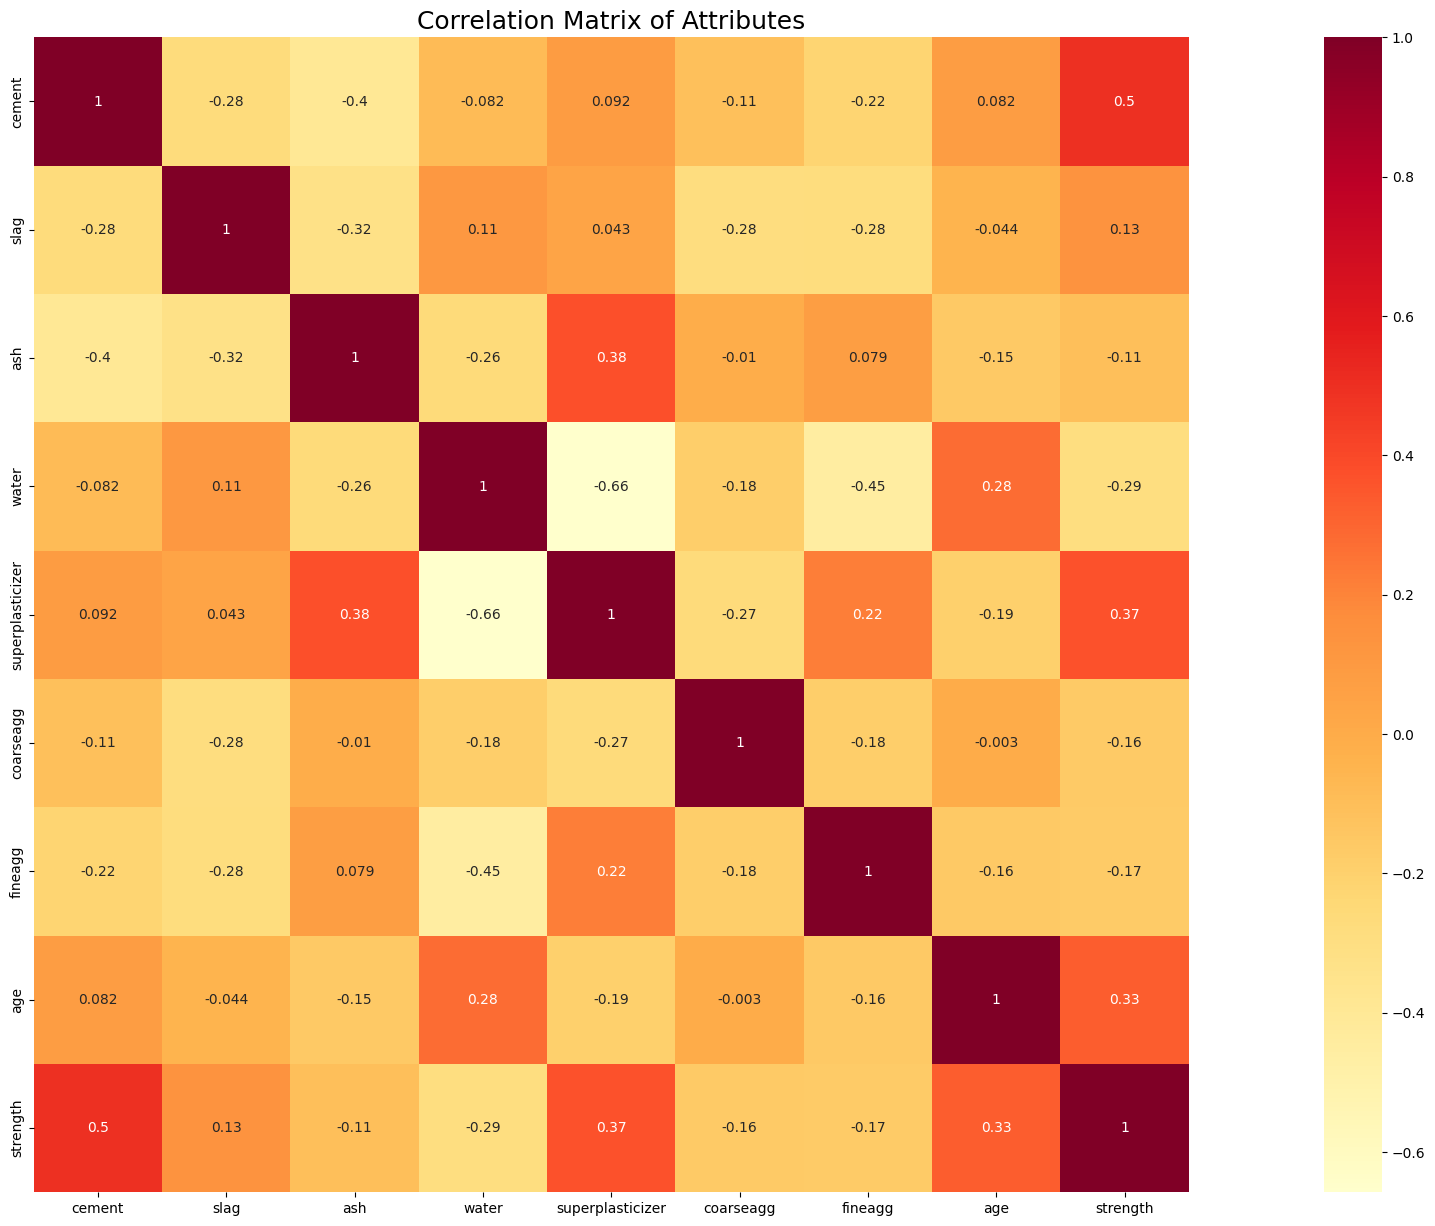

In [128]:
plt.figure(figsize=(35,15))

sns.heatmap(df.corr(),vmax=1, square=True, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix of Attributes', fontsize=18)
plt.savefig('pearson_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# SECTION 3: OUTLIER DETECTION (For SVR only)

In [129]:
def detect_outliers_zscore(df, features, threshold=5, method='zscore'):
    outlier_mask = pd.Series(True, index=df.index)
    outlier_summary = {}
    
    for feature in features:
        if method == 'zscore':
            z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
            outlier_count = (z_scores > threshold).sum()
        elif method == 'iqr':
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            outlier_count = ((df[feature] < Q1 - 1.5 * IQR) | 
                           (df[feature] > Q3 + 1.5 * IQR)).sum()
        
        outlier_summary[feature] = outlier_count
        outlier_mask = outlier_mask & (z_scores <= threshold)
    
    return outlier_mask, outlier_summary

# Use the function
raw_features = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 
                'coarseagg', 'fineagg', 'age', 'strength']

outlier_mask, outlier_summary = detect_outliers_zscore(
    df, raw_features, threshold=5, method='zscore'
)

# Print results neatly
print("OUTLIER DETECTION SUMMARY (Z-score method, threshold = 5 SD)")
for feature, count in outlier_summary.items():
    pct = count / len(df) * 100
    print(f"  {feature:25s}: {count:3d} outliers ({pct:5.2f}%)")

print(f"\n{"Total samples with outliers":25s}: {(~outlier_mask).sum()}")
print(f"{"Clean samples":25s}: {outlier_mask.sum()} ({outlier_mask.sum()/len(df)*100:.2f}%)")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTLIER DETECTION SUMMARY (Z-score method, threshold = 5 SD)
  cement                   :   0 outliers ( 0.00%)
  slag                     :   0 outliers ( 0.00%)
  ash                      :   0 outliers ( 0.00%)
  water                    :   0 outliers ( 0.00%)
  superplasticizer         :   0 outliers ( 0.00%)
  coarseagg                :   0 outliers ( 0.00%)
  fineagg                  :   0 outliers ( 0.00%)
  age                      :  14 outliers ( 1.36%)
  strength                 :   0 outliers ( 0.00%)

Total samples with outliers: 14
Clean samples            : 1016 (98.64%)


# SECTION 4: FEATURE ENGINEERING (Apply to both datasets)
# Add ratios and age bins to BOTH X (with outliers) and X_clean (without)

In [130]:
#New Ratios between features
df_engineered = df.copy()

df_engineered['water_cement_ratio'] = df['water'] / df['cement']
df_engineered['binder_total'] = df['cement'] + df['slag'] + df['ash']

#Age binning
bins = [0, 1, 3, 7, 14, 28, 56, 90, 180, 365]
labels = ['very_early', 'very_early2', 'early', 'early2', 'week1', 
          'week2', 'month3', 'month6', 'year1']
df_engineered['age_category'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)
df_engineered['age_bin'] = pd.cut(df['age'], bins=bins, include_lowest=True).cat.codes
#Age indicators
df_engineered['is_very_early'] = (df['age'] <= 3).astype(int)
df_engineered['is_early_cure'] = ((df['age'] > 3) & (df['age'] <= 7)).astype(int)
df_engineered['is_7day'] = (df['age'] == 7).astype(int)
df_engineered['is_28day'] = (df['age'] == 28).astype(int)
df_engineered['is_mature'] = (df['age'] >= 28).astype(int)
df_engineered['is_very_mature'] = (df['age'] >= 90).astype(int)

#Binary Indicators for zero-inflated features
df_engineered['has_slag'] = (df['slag'] > 0).astype(int)
df_engineered['has_ash'] = (df['ash'] > 0).astype(int)
df_engineered['has_superplasticizer'] = (df['superplasticizer'] > 0).astype(int)

#Checking the new features
print(df_engineered.head())
print(df_engineered.columns)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   cement   slag  ash  water  superplasticizer  coarseagg  fineagg  age  \
0   540.0    0.0  0.0  162.0               2.5     1040.0    676.0   28   
1   540.0    0.0  0.0  162.0               2.5     1055.0    676.0   28   
2   332.5  142.5  0.0  228.0               0.0      932.0    594.0  270   
3   332.5  142.5  0.0  228.0               0.0      932.0    594.0  365   
4   198.6  132.4  0.0  192.0               0.0      978.4    825.5  360   

   strength  water_cement_ratio  ...  age_bin is_very_early  is_early_cure  \
0     79.99            0.300000  ...        4             0              0   
1     61.89            0.300000  ...        4             0              0   
2     40.27            0.685714  ...        8             0              0   
3     41.05            0.685714  ...        8             0              0   
4     44.30            0.966767  ...        8             0              0   

   is_7day  is_28day  is_mature  is_very_mature  has_slag  has_ash  \
0        0

# SECTION 5: CREATE TWO DATASETS USING outlier_mask

In [131]:
print("CREATING TWO DATASETS: WITH & WITHOUT OUTLIERS")

# DATASET 1: WITH OUTLIERS (for tree-based models)
X_with_outliers = df_engineered.drop(columns=['strength', 'age_category', 'age'])
y_with_outliers = df_engineered['strength']

print(f"\nDataset 1 - WITH OUTLIERS (for tree-based models):")
print(f"  Total samples: {len(X_with_outliers)}")
print(f"  Features: {X_with_outliers.shape[1]}")

# DATASET 2: WITHOUT OUTLIERS (for SVR)
df_clean = df_engineered[outlier_mask].copy()
X_without_outliers = df_clean.drop(columns=['strength', 'age_category', 'age'])  # FIX HERE
y_without_outliers = df_clean['strength']

print(f"\nDataset 2 - WITHOUT OUTLIERS (for SVR):")
print(f"  Clean samples: {len(X_without_outliers)}")
print(f"  Features: {X_without_outliers.shape[1]}")
print(f"  Outliers removed: {len(X_with_outliers) - len(X_without_outliers)}")


CREATING TWO DATASETS: WITH & WITHOUT OUTLIERS

Dataset 1 - WITH OUTLIERS (for tree-based models):
  Total samples: 1030
  Features: 19

Dataset 2 - WITHOUT OUTLIERS (for SVR):
  Clean samples: 1016
  Features: 19
  Outliers removed: 14


# SECTION 6.1: CREATE TWO-WAY SPLITS, TRAIN/VAL/TEST

In [132]:
# DATASET 1: WITH OUTLIERS (for Tree-based models)
print("Dataset 1: THREE-WAY SPLIT WITH OUTLIERS (Random Forest & XGBoost)")

# Second split: 75% train, 25% validation (of the 70%)
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_with_outliers, y_with_outliers, test_size=0.2, random_state=42)

print(f"Train set: {X_train_with.shape[0]} samples (80%)")
print(f"Test set:  {X_test_with.shape[0]} samples (20%)")

# DATASET 2: WITHOUT OUTLIERS (for SVR)
print("\nDataset 2: THREE-WAY SPLIT WITHOUT OUTLIERS (SVR)")

# Second split: 75% train, 25% validation
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_without_outliers, y_without_outliers, test_size=0.2, random_state=42)

print(f"Train set: {X_train_clean.shape[0]} samples (80%)")
print(f"Test set:  {X_test_clean.shape[0]} samples (20%)")

Dataset 1: THREE-WAY SPLIT WITH OUTLIERS (Random Forest & XGBoost)


<IPython.core.display.Javascript object>

Train set: 824 samples (80%)
Test set:  206 samples (20%)

Dataset 2: THREE-WAY SPLIT WITHOUT OUTLIERS (SVR)


<IPython.core.display.Javascript object>

Train set: 812 samples (80%)
Test set:  204 samples (20%)


# SECTION 7: RANDOM FOREST

# SECTION 7.1: RF - BAYESIAN OPTIMIZATION 

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# Pipeline (No scaler needed for Random Forest)
rf_pipe = Pipeline([('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Define Bayesian search space
# Note the 'rf__' prefix to match the pipeline step name
search_space_rf_bayes = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Bayesian Optimization
print("\nPerforming Bayesian Optimization (Random Forest)...")
start_time = time.time()

bayes_search_rf = BayesSearchCV(
    estimator=rf_pipe,
    search_spaces=search_space_rf_bayes,
    n_iter=40,              # 40 iterations
    cv=5,                   # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search_rf.fit(X_train_with, y_train_with)
elapsed_time = time.time() - start_time

# Results
print("Random Forest - Bayesian Optimization Results")
print(f"\nBest Parameters Found:")
print(f"  n_estimators: {bayes_search_rf.best_params_['rf__n_estimators']}")
print(f"  max_depth: {bayes_search_rf.best_params_['rf__max_depth']}")
print(f"  min_samples_split: {bayes_search_rf.best_params_['rf__min_samples_split']}")
print(f"  min_samples_leaf: {bayes_search_rf.best_params_['rf__min_samples_leaf']}")

print(f"\nBest CV R² Score: {bayes_search_rf.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_rf_bayes = bayes_search_rf.best_estimator_

# Predictions
print("\nMaking predictions...")
rf_train_pred_bayes = best_rf_bayes.predict(X_train_with)
rf_test_pred_bayes = best_rf_bayes.predict(X_test_with)

# Metrics
# Train
rf_train_rmse_bayes = np.sqrt(mean_squared_error(y_train_with, rf_train_pred_bayes))
rf_train_mae_bayes  = mean_absolute_error(y_train_with, rf_train_pred_bayes)
rf_train_r2_bayes   = r2_score(y_train_with, rf_train_pred_bayes)
rf_train_mape_bayes = np.mean(np.abs((y_train_with - rf_train_pred_bayes) / y_train_with)) * 100

# Test
rf_test_rmse_bayes = np.sqrt(mean_squared_error(y_test_with, rf_test_pred_bayes))
rf_test_mae_bayes  = mean_absolute_error(y_test_with, rf_test_pred_bayes)
rf_test_r2_bayes   = r2_score(y_test_with, rf_test_pred_bayes)
rf_test_mape_bayes = np.mean(np.abs((y_test_with - rf_test_pred_bayes) / y_test_with)) * 100

print("Random Forest Bayesian Optimization Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {rf_train_rmse_bayes:.4f} MPa")
print(f"  MAE:  {rf_train_mae_bayes:.4f} MPa")
print(f"  MAPE: {rf_train_mape_bayes:.2f}%")
print(f"  R²:   {rf_train_r2_bayes:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {rf_test_rmse_bayes:.4f} MPa")
print(f"  MAE:  {rf_test_mae_bayes:.4f} MPa")
print(f"  MAPE: {rf_test_mape_bayes:.2f}%")
print(f"  R²:   {rf_test_r2_bayes:.4f}")


Performing Bayesian Optimization (Random Forest)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fit

C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20), np.int64(1), np.int64(2), np.int64(400)] before, using random point [50, 1, 2, 300]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20), np.int64(1), np.int64(2), np.int64(400)] before, using random point [40, 2, 5, 500]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest - Bayesian Optimization Results

Best Parameters Found:
  n_estimators: 400
  max_depth: 20
  min_samples_split: 2
  min_samples_leaf: 1

Best CV R² Score: 0.9099
Search Time: 4.06 minutes

Making predictions...
Random Forest Bayesian Optimization Performance

Training Set:
  RMSE: 1.9113 MPa
  MAE:  1.2119 MPa
  MAPE: 4.34%
  R²:   0.9871

Test Set:
  RMSE: 5.2138 MPa
  MAE:  3.4605 MPa
  MAPE: 11.34%
  R²:   0.8945


# SECTION 7.2: RF - GRIDSEARCHCV

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Pipeline (no scaler needed for RF)
rf_pipe = Pipeline([('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Grid search space (explicit value grids instead of ranges)
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Grid Search
print("\nPerforming Grid Search (Random Forest)...")
start_time = time.time()

grid_search_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_with, y_train_with)
elapsed_time = time.time() - start_time

# Results
print("Random Forest - Grid Search Results")
print(f"\nBest Parameters Found:")
print(f"  n_estimators: {grid_search_rf.best_params_['rf__n_estimators']}")
print(f"  max_depth: {grid_search_rf.best_params_['rf__max_depth']}")
print(f"  min_samples_split: {grid_search_rf.best_params_['rf__min_samples_split']}")
print(f"  min_samples_leaf: {grid_search_rf.best_params_['rf__min_samples_leaf']}")

print(f"\nBest CV R² Score: {grid_search_rf.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_rf_grid = grid_search_rf.best_estimator_

# Predictions
print("\nMaking predictions...")
rf_train_pred_grid = best_rf_grid.predict(X_train_with)
rf_test_pred_grid = best_rf_grid.predict(X_test_with)

# Metrics
# Train
rf_train_rmse_grid = np.sqrt(mean_squared_error(y_train_with, rf_train_pred_grid))
rf_train_mae_grid  = mean_absolute_error(y_train_with, rf_train_pred_grid)
rf_train_r2_grid   = r2_score(y_train_with, rf_train_pred_grid)
rf_train_mape_grid = np.mean(
    np.abs((y_train_with - rf_train_pred_grid) / y_train_with)
) * 100

# Test
rf_test_rmse_grid = np.sqrt(mean_squared_error(y_test_with, rf_test_pred_grid))
rf_test_mae_grid  = mean_absolute_error(y_test_with, rf_test_pred_grid)
rf_test_r2_grid   = r2_score(y_test_with, rf_test_pred_grid)
rf_test_mape_grid = np.mean(
    np.abs((y_test_with - rf_test_pred_grid) / y_test_with)
) * 100

print("Random Forest Grid Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {rf_train_rmse_grid:.4f} MPa")
print(f"  MAE:  {rf_train_mae_grid:.4f} MPa")
print(f"  MAPE: {rf_train_mape_grid:.2f}%")
print(f"  R²:   {rf_train_r2_grid:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {rf_test_rmse_grid:.4f} MPa")
print(f"  MAE:  {rf_test_mae_grid:.4f} MPa")
print(f"  MAPE: {rf_test_mape_grid:.2f}%")
print(f"  R²:   {rf_test_r2_grid:.4f}")


# SECTION 7.3: RF - RANDOMSEARCHCV

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Pipeline (no scaler needed for RF)
rf_pipe = Pipeline([('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Random search space 
param_distributions_rf = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Random Search
print("\nPerforming Random Search (Random Forest)...")
start_time = time.time()

random_search_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_distributions_rf,
    n_iter=40,          # number of random combinations to try
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train_with, y_train_with)
elapsed_time = time.time() - start_time

# Results
print("Random Forest - Random Search Results")
print(f"\nBest Parameters Found:")
print(f"  n_estimators: {random_search_rf.best_params_['rf__n_estimators']}")
print(f"  max_depth: {random_search_rf.best_params_['rf__max_depth']}")
print(f"  min_samples_split: {random_search_rf.best_params_['rf__min_samples_split']}")
print(f"  min_samples_leaf: {random_search_rf.best_params_['rf__min_samples_leaf']}")

print(f"\nBest CV R² Score: {random_search_rf.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_rf_random = random_search_rf.best_estimator_

# Predictions
print("\nMaking predictions...")
rf_train_pred_random = best_rf_random.predict(X_train_with)
rf_test_pred_random = best_rf_random.predict(X_test_with)

# Metrics
# Train
rf_train_rmse_random = np.sqrt(mean_squared_error(y_train_with, rf_train_pred_random))
rf_train_mae_random  = mean_absolute_error(y_train_with, rf_train_pred_random)
rf_train_r2_random   = r2_score(y_train_with, rf_train_pred_random)
rf_train_mape_random = np.mean(np.abs((y_train_with - rf_train_pred_random) / y_train_with)) * 100

# Test
rf_test_rmse_random = np.sqrt(mean_squared_error(y_test_with, rf_test_pred_random))
rf_test_mae_random  = mean_absolute_error(y_test_with, rf_test_pred_random)
rf_test_r2_random   = r2_score(y_test_with, rf_test_pred_random)
rf_test_mape_random = np.mean(np.abs((y_test_with - rf_test_pred_random) / y_test_with)) * 100

print("Random Forest Random Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {rf_train_rmse_random:.4f} MPa")
print(f"  MAE:  {rf_train_mae_random:.4f} MPa")
print(f"  MAPE: {rf_train_mape_random:.2f}%")
print(f"  R²:   {rf_train_r2_random:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {rf_test_rmse_random:.4f} MPa")
print(f"  MAE:  {rf_test_mae_random:.4f} MPa")
print(f"  MAPE: {rf_test_mape_random:.2f}%")
print(f"  R²:   {rf_test_r2_random:.4f}")


Performing Random Search (Random Forest)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Random Forest - Random Search Results

Best Parameters Found:
  n_estimators: 300
  max_depth: 50
  min_samples_split: 2
  min_samples_leaf: 1

Best CV R² Score: 0.9095
Search Time: 1.99 minutes

Making predictions...
Random Forest Random Search Performance

Training Set:
  RMSE: 1.9161 MPa
  MAE:  1.2148 MPa
  MAPE: 4.34%
  R²:   0.9871

Test Set:
  RMSE: 5.2576 MPa
  MAE:  3.4565 MPa
  MAPE: 11.28%
  R²:   0.8927


# SECTION 7.4: RF HYPERPARAMETER TEST COMPARISON

In [18]:
comparison_data_rf = {
    'Method': ['Bayesian Optimization', 'Grid Search', 'Random Search'],
    'Best CV R²': [
        f"{bayes_search_rf.best_score_:.4f}",
        f"{grid_search_rf.best_score_:.4f}",
        f"{random_search_rf.best_score_:.4f}"
    ],
    'Train R²': [
        f"{rf_train_r2_bayes:.4f}",
        f"{rf_train_r2_grid:.4f}",
        f"{rf_train_r2_random:.4f}"
    ],
    'Train RMSE (MPa)': [
        f"{rf_train_rmse_bayes:.4f}",
        f"{rf_train_rmse_grid:.4f}",
        f"{rf_train_rmse_random:.4f}"
    ],
    'Train MAE (MPa)': [
        f"{rf_train_mae_bayes:.4f}",
        f"{rf_train_mae_grid:.4f}",
        f"{rf_train_mae_random:.4f}"
    ],
    'Train MAPE (%)': [
        f"{rf_train_mape_bayes:.2f}",
        f"{rf_train_mape_grid:.2f}",
        f"{rf_train_mape_random:.2f}"
    ],
    'Test R²': [
        f"{rf_test_r2_bayes:.4f}",
        f"{rf_test_r2_grid:.4f}",
        f"{rf_test_r2_random:.4f}"
    ],
    'Test RMSE (MPa)': [
        f"{rf_test_rmse_bayes:.4f}",
        f"{rf_test_rmse_grid:.4f}",
        f"{rf_test_rmse_random:.4f}"
    ],
    'Test MAE (MPa)': [
        f"{rf_test_mae_bayes:.4f}",
        f"{rf_test_mae_grid:.4f}",
        f"{rf_test_mae_random:.4f}"
    ],
    'Test MAPE (%)': [
        f"{rf_test_mape_bayes:.2f}",
        f"{rf_test_mape_grid:.2f}",
        f"{rf_test_mape_random:.2f}"
    ]
}

comp_df_rf = pd.DataFrame(comparison_data_rf)
print(comp_df_rf.to_string(index=False))

<IPython.core.display.Javascript object>

               Method Best CV Score Test R² Test RMSE (MPa) Test MAE (MPa)
Bayesian Optimization        0.8877  0.8904          5.3154         3.7099
          Grid Search        0.8877  0.8904          5.3154         3.7099


# SECTION 8: XGBOOST

# SECTION 8.1: XGBOOST - BAYESIAN OPTIMIZATION 

In [116]:
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Base XGBoost model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Bayesian search space (mirrors your grid ranges)
search_space_xgb_bayes = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(4, 10),
    'learning_rate': Real(0.01, 0.2),   # continuous between min/max grid
    'reg_alpha': Real(0.0, 0.1),        # small L1
    'reg_lambda': Real(0.1, 10.0)       # L2
}

print("\nPerforming Bayesian Optimization (XGBoost)...")
start_time = time.time()

bayes_search_xgb = BayesSearchCV(
    estimator=xgb_base,
    search_spaces=search_space_xgb_bayes,
    n_iter=40,              # same budget idea as RF
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search_xgb.fit(X_train_with, y_train_with)
elapsed_time_bayes = time.time() - start_time

# Results
print("\n" + "=" * 80)
print("XGBoost - Bayesian Optimization Results")
print("=" * 80)
print(f"\nBest Parameters Found (BayesSearchCV):")
for param, value in bayes_search_xgb.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nBest CV R² Score (BayesSearchCV): {bayes_search_xgb.best_score_:.4f}")
print(f"Search Time: {elapsed_time_bayes:.2f} seconds ({elapsed_time_bayes/60:.2f} minutes)")

# Best model
best_xgb_bayes = bayes_search_xgb.best_estimator_

# Predictions
print("\nMaking predictions with best BayesSearchCV model...")
xgb_bayes_train_pred = best_xgb_bayes.predict(X_train_with)
xgb_bayes_test_pred  = best_xgb_bayes.predict(X_test_with)

# Metrics
# Train
xgb_bayes_train_rmse = np.sqrt(mean_squared_error(y_train_with, xgb_bayes_train_pred))
xgb_bayes_train_mae  = mean_absolute_error(y_train_with, xgb_bayes_train_pred)
xgb_bayes_train_r2   = r2_score(y_train_with, xgb_bayes_train_pred)
xgb_bayes_train_mape = np.mean(np.abs((y_train_with - xgb_bayes_train_pred) / y_train_with)) * 100

# Test
xgb_bayes_test_rmse = np.sqrt(mean_squared_error(y_test_with, xgb_bayes_test_pred))
xgb_bayes_test_mae  = mean_absolute_error(y_test_with, xgb_bayes_test_pred)
xgb_bayes_test_r2   = r2_score(y_test_with, xgb_bayes_test_pred)
xgb_bayes_test_mape = np.mean(np.abs((y_test_with - xgb_bayes_test_pred) / y_test_with)) * 100

print("\nXGBoost Bayesian Optimization Performance")
print("-" * 80)
print(f"\nTraining Set:")
print(f"  RMSE: {xgb_bayes_train_rmse:.4f} MPa")
print(f"  MAE:  {xgb_bayes_train_mae:.4f} MPa")
print(f"  MAPE: {xgb_bayes_train_mape:.2f}%")
print(f"  R²:   {xgb_bayes_train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {xgb_bayes_test_rmse:.4f} MPa")
print(f"  MAE:  {xgb_bayes_test_mae:.4f} MPa")
print(f"  MAPE: {xgb_bayes_test_mape:.2f}%")
print(f"  R²:   {xgb_bayes_test_r2:.4f}")



Performing Bayesian Optimization (XGBoost)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5

# SECTION 8.2: XGBOOST - GRIDSEARCHCV

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time

# Base XGBoost model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Grid search space (matches your earlier grid)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'reg_alpha': [0.0, 0.01, 0.1],
    'reg_lambda': [0.1, 1.0, 10.0]
}

print("\nGridSearchCV Parameter Space:")
total_combinations = np.prod([len(v) for v in param_grid_xgb.values()])
print(f"  • Total combinations: {total_combinations}")
for param, values in param_grid_xgb.items():
    print(f"    - {param}: {values}")

print("\nPerforming GridSearchCV (XGBoost)...")
start_time = time.time()

grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train_with, y_train_with)
elapsed_time_grid = time.time() - start_time

print("\n" + "=" * 80)
print("XGBoost - GridSearchCV Results")
print("=" * 80)
print(f"\nBest Parameters Found (GridSearchCV):")
for param, value in grid_search_xgb.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nBest CV R² Score (GridSearchCV): {grid_search_xgb.best_score_:.4f}")
print(f"Search Time: {elapsed_time_grid:.2f} seconds ({elapsed_time_grid/60:.2f} minutes)")

# Best model
best_xgb_grid = grid_search_xgb.best_estimator_

# Predictions
print("\nMaking predictions with best GridSearchCV model...")
xgb_grid_train_pred = best_xgb_grid.predict(X_train_with)
xgb_grid_test_pred  = best_xgb_grid.predict(X_test_with)

# Metrics
# Train
xgb_grid_train_rmse = np.sqrt(mean_squared_error(y_train_with, xgb_grid_train_pred))
xgb_grid_train_mae  = mean_absolute_error(y_train_with, xgb_grid_train_pred)
xgb_grid_train_r2   = r2_score(y_train_with, xgb_grid_train_pred)
xgb_grid_train_mape = np.mean(np.abs((y_train_with - xgb_grid_train_pred) / y_train_with)) * 100

# Test
xgb_grid_test_rmse = np.sqrt(mean_squared_error(y_test_with, xgb_grid_test_pred))
xgb_grid_test_mae  = mean_absolute_error(y_test_with, xgb_grid_test_pred)
xgb_grid_test_r2   = r2_score(y_test_with, xgb_grid_test_pred)
xgb_grid_test_mape = np.mean(np.abs((y_test_with - xgb_grid_test_pred) / y_test_with)) * 100

print("\nXGBoost GridSearchCV Performance")
print("-" * 80)
print(f"\nTraining Set:")
print(f"  RMSE: {xgb_grid_train_rmse:.4f} MPa")
print(f"  MAE:  {xgb_grid_train_mae:.4f} MPa")
print(f"  MAPE: {xgb_grid_train_mape:.2f}%")
print(f"  R²:   {xgb_grid_train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {xgb_grid_test_rmse:.4f} MPa")
print(f"  MAE:  {xgb_grid_test_mae:.4f} MPa")
print(f"  MAPE: {xgb_grid_test_mape:.2f}%")
print(f"  R²:   {xgb_grid_test_r2:.4f}")


# SECTION 8.3: XGBOOST - RANDOMSEARCHCV

In [118]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time

# Base XGBoost model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Random search space (same value lists as grid)
param_distributions_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'reg_alpha': [0.0, 0.01, 0.1],
    'reg_lambda': [0.1, 1.0, 10.0]
}

print("\nRandomizedSearchCV Parameter Space:")
total_combinations = np.prod([len(v) for v in param_distributions_xgb.values()])
print(f"  • Total possible combinations: {total_combinations}")
for param, values in param_distributions_xgb.items():
    print(f"    - {param}: {values}")

print("\nPerforming RandomizedSearchCV (XGBoost)...")
start_time = time.time()

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions_xgb,
    n_iter=40,         # number of random combinations to try
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train_with, y_train_with)
elapsed_time_rand = time.time() - start_time

print("\n" + "=" * 80)
print("XGBoost - RandomizedSearchCV Results")
print("=" * 80)
print(f"\nBest Parameters Found (RandomizedSearchCV):")
for param, value in random_search_xgb.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nBest CV R² Score (RandomizedSearchCV): {random_search_xgb.best_score_:.4f}")
print(f"Search Time: {elapsed_time_rand:.2f} seconds ({elapsed_time_rand/60:.2f} minutes)")

# Best model
best_xgb_random = random_search_xgb.best_estimator_

# Predictions
print("\nMaking predictions with best RandomizedSearchCV model...")
xgb_random_train_pred = best_xgb_random.predict(X_train_with)
xgb_random_test_pred  = best_xgb_random.predict(X_test_with)

# Metrics
# Train
xgb_random_train_rmse = np.sqrt(mean_squared_error(y_train_with, xgb_random_train_pred))
xgb_random_train_mae  = mean_absolute_error(y_train_with, xgb_random_train_pred)
xgb_random_train_r2   = r2_score(y_train_with, xgb_random_train_pred)
xgb_random_train_mape = np.mean(np.abs((y_train_with - xgb_random_train_pred) / y_train_with)) * 100

# Test
xgb_random_test_rmse = np.sqrt(mean_squared_error(y_test_with, xgb_random_test_pred))
xgb_random_test_mae  = mean_absolute_error(y_test_with, xgb_random_test_pred)
xgb_random_test_r2   = r2_score(y_test_with, xgb_random_test_pred)
xgb_random_test_mape = np.mean(np.abs((y_test_with - xgb_random_test_pred) / y_test_with)) * 100

print("\nXGBoost RandomizedSearchCV Performance")
print("-" * 80)
print(f"\nTraining Set:")
print(f"  RMSE: {xgb_random_train_rmse:.4f} MPa")
print(f"  MAE:  {xgb_random_train_mae:.4f} MPa")
print(f"  MAPE: {xgb_random_train_mape:.2f}%")
print(f"  R²:   {xgb_random_train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {xgb_random_test_rmse:.4f} MPa")
print(f"  MAE:  {xgb_random_test_mae:.4f} MPa")
print(f"  MAPE: {xgb_random_test_mape:.2f}%")
print(f"  R²:   {xgb_random_test_r2:.4f}")


RandomizedSearchCV Parameter Space:
  • Total possible combinations: 432
    - n_estimators: [100, 200, 300]
    - max_depth: [4, 6, 8, 10]
    - learning_rate: [0.01, 0.05, 0.1, 0.2]
    - reg_alpha: [0.0, 0.01, 0.1]
    - reg_lambda: [0.1, 1.0, 10.0]

Performing RandomizedSearchCV (XGBoost)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

XGBoost - RandomizedSearchCV Results

Best Parameters Found (RandomizedSearchCV):
  • reg_lambda: 10.0
  • reg_alpha: 0.0
  • n_estimators: 200
  • max_depth: 4
  • learning_rate: 0.2

Best CV R² Score (RandomizedSearchCV): 0.9242
Search Time: 94.88 seconds (1.58 minutes)

Making predictions with best RandomizedSearchCV model...

XGBoost RandomizedSearchCV Performance
--------------------------------------------------------------------------------

Training Set:
  RMSE: 1.9200 MPa
  MAE:  1.2593 MPa
  MAPE: 4.53%
  R²:   0.9870

Test Set:
  RMSE: 4.3514 MPa
  MAE:  2.9949 MPa
  MAPE: 9.83%
  R²:   0.9265


# SECTION 8.3: XGBOOST HYPERPARAMETER TEST COMPARISON

In [22]:
comparison_data_xgb = {
    'Method': ['Bayesian Optimization', 'Grid Search', 'Random Search'],
    'Best CV R²': [
        f"{bayes_search_xgb.best_score_:.4f}",
        f"{grid_search_xgb.best_score_:.4f}",
        f"{random_search_xgb.best_score_:.4f}"
    ],
    'Train R²': [
        f"{xgb_bayes_train_r2:.4f}",
        f"{xgb_grid_train_r2:.4f}",
        f"{xgb_random_train_r2:.4f}"
    ],
    'Train RMSE (MPa)': [
        f"{xgb_bayes_train_rmse:.4f}",
        f"{xgb_grid_train_rmse:.4f}",
        f"{xgb_random_train_rmse:.4f}"
    ],
    'Train MAE (MPa)': [
        f"{xgb_bayes_train_mae:.4f}",
        f"{xgb_grid_train_mae:.4f}",
        f"{xgb_random_train_mae:.4f}"
    ],
    'Train MAPE (%)': [
        f"{xgb_bayes_train_mape:.2f}",
        f"{xgb_grid_train_mape:.2f}",
        f"{xgb_random_train_mape:.2f}"
    ],
    'Test R²': [
        f"{xgb_bayes_test_r2:.4f}",
        f"{xgb_grid_test_r2:.4f}",
        f"{xgb_random_test_r2:.4f}"
    ],
    'Test RMSE (MPa)': [
        f"{xgb_bayes_test_rmse:.4f}",
        f"{xgb_grid_test_rmse:.4f}",
        f"{xgb_random_test_rmse:.4f}"
    ],
    'Test MAE (MPa)': [
        f"{xgb_bayes_test_mae:.4f}",
        f"{xgb_grid_test_mae:.4f}",
        f"{xgb_random_test_mae:.4f}"
    ],
    'Test MAPE (%)': [
        f"{xgb_bayes_test_mape:.2f}",
        f"{xgb_grid_test_mape:.2f}",
        f"{xgb_random_test_mape:.2f}"
    ]
}

comp_df_xgb = pd.DataFrame(comparison_data_xgb)
print(comp_df_xgb.to_string(index=False))


<IPython.core.display.Javascript object>

               Method Best CV Score Test R² Test RMSE (MPa) Test MAE (MPa)
Bayesian Optimization        0.9132  0.9168          4.6308         3.1631
          Grid Search        0.9132  0.9168          4.6308         3.1631


# SECTION 9: SVR

# SECTION 9.1: SVR - BAYESIAN OPTIMIZATION

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Pipeline prevents leakage
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define Bayesian search space
search_space_svr_bayes = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [10, 50, 100, 200, 300, 500],
    'svr__gamma': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
    'svr__epsilon': [1.0, 2.0, 3.0, 4.0],
    'svr__degree': [2, 3]  # used only when kernel='poly'
}

# Bayesian Optimization
print("\nPerforming Bayesian Optimization...")
start_time = time.time()

bayes_search_svr = BayesSearchCV(
    estimator=svr_pipe,
    search_spaces=search_space_svr_bayes,
    n_iter=50,          # number of Bayesian optimization steps
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search_svr.fit(X_train_clean, y_train_clean)
elapsed_time = time.time() - start_time

# Results
print("SVR - Bayesian Optimization Results")
print(f"\nBest Parameters Found:")
print(f"  C: {bayes_search_svr.best_params_['svr__C']:.4f}")
print(f"  gamma: {bayes_search_svr.best_params_['svr__gamma']:.6f}")
print(f"  epsilon: {bayes_search_svr.best_params_['svr__epsilon']:.4f}")
print(f"  kernel: {bayes_search_svr.best_params_['svr__kernel']}")
print(f"  degree: {bayes_search_svr.best_params_['svr__degree']}")

print(f"\nBest CV R² Score: {bayes_search_svr.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_svr_bayes = bayes_search_svr.best_estimator_

# Predictions
print("\nMaking predictions...")
svr_train_pred_bayes = best_svr_bayes.predict(X_train_clean)
svr_test_pred_bayes = best_svr_bayes.predict(X_test_clean)

# Metrics
# Train
svr_train_rmse_bayes = np.sqrt(mean_squared_error(y_train_clean, svr_train_pred_bayes))
svr_train_mae_bayes  = mean_absolute_error(y_train_clean, svr_train_pred_bayes)
svr_train_r2_bayes   = r2_score(y_train_clean, svr_train_pred_bayes)
svr_train_mape_bayes = np.mean(np.abs((y_train_clean - svr_train_pred_bayes) / y_train_clean)) * 100

# Test
svr_test_rmse_bayes = np.sqrt(mean_squared_error(y_test_clean, svr_test_pred_bayes))
svr_test_mae_bayes  = mean_absolute_error(y_test_clean, svr_test_pred_bayes)
svr_test_r2_bayes   = r2_score(y_test_clean, svr_test_pred_bayes)
svr_test_mape_bayes = np.mean(np.abs((y_test_clean - svr_test_pred_bayes) / y_test_clean)) * 100

print("SVR Bayesian Optimization Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {svr_train_rmse_bayes:.4f} MPa")
print(f"  MAE:  {svr_train_mae_bayes:.4f} MPa")
print(f"  MAPE: {svr_train_mape_bayes:.2f}%")
print(f"  R²:   {svr_train_r2_bayes:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {svr_test_rmse_bayes:.4f} MPa")
print(f"  MAE:  {svr_test_mae_bayes:.4f} MPa")
print(f"  MAPE: {svr_test_mape_bayes:.2f}%")
print(f"  R²:   {svr_test_r2_bayes:.4f}")




Performing Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\lucar\AppData\Local\Packages\PythonSoftwa

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(200), np.int64(3), np.float64(2.0), np.float64(0.05), np.str_('rbf')] before, using random point [300, np.int64(3), 1.0, 0.1, 'rbf']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(50), np.int64(3), np.float64(1.0), np.float64(0.05), np.str_('rbf')] before, using random point [500, np.int64(2), 1.0, 0.05, 'rbf']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(200), np.int64(3), np.float64(2.0), np.float64(0.005), np.str_('rbf')] before, using random point [100, np.int64(2), 2.0, 0.1, 'rbf']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(100), np.int64(2), np.float64(1.0), np.float64(0.05), np.str_('rbf')] before, using random point [300, np.int64(3), 4.0, 0.0005, 'poly']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(100), np.int64(3), np.float64(1.0), np.float64(0.05), np.str_('rbf')] before, using random point [200, np.int64(2), 2.0, 0.001, 'rbf']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(100), np.int64(3), np.float64(1.0), np.float64(0.05), np.str_('rbf')] before, using random point [300, np.int64(3), 3.0, 0.005, 'rbf']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(300), np.int64(3), np.float64(1.0), np.float64(0.001), np.str_('rbf')] before, using random point [100, np.int64(2), 3.0, 0.005, 'rbf']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(500), np.int64(2), np.float64(1.0), np.float64(0.001), np.str_('rbf')] before, using random point [50, np.int64(2), 4.0, 0.1, 'poly']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVR - Bayesian Optimization Results

Best Parameters Found:
  C: 100.0000
  gamma: 0.050000
  epsilon: 1.0000
  kernel: rbf
  degree: 2

Best CV R² Score: 0.8947
Search Time: 2.86 minutes

Making predictions...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SVR Bayesian Optimization Performance

Training Set:
  RMSE: 3.5387 MPa
  MAE:  2.1451 MPa
  MAPE: 7.02%
  R²:   0.9556

Test Set:
  RMSE: 4.8279 MPa
  MAE:  3.4702 MPa
  MAPE: 11.56%
  R²:   0.9147


# SECTION 9.2: SVR - GRIDSEARCH

In [140]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Pipeline prevents leakage
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define search space (matching your structure)
search_space_svr = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [10, 50, 100, 200, 300, 500],
    'svr__gamma': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
    'svr__epsilon': [1.0, 2.0, 3.0, 4.0],
    'svr__degree': [2, 3]  # used only when kernel='poly'
}

# Grid Search
print("\nPerforming Grid Search...")
start_time = time.time()

grid_search_svr = GridSearchCV(
    estimator=svr_pipe,
    param_grid=search_space_svr,
    cv=5,                   # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_svr.fit(X_train_clean, y_train_clean)

elapsed_time = time.time() - start_time

# Print results
print("SVR - Grid Search Results")
print(f"\nBest Parameters Found:")
print(f"  C: {grid_search_svr.best_params_['svr__C']:.4f}")
print(f"  gamma: {grid_search_svr.best_params_['svr__gamma']}")
print(f"  epsilon: {grid_search_svr.best_params_['svr__epsilon']:.4f}")
print(f"  kernel: {grid_search_svr.best_params_['svr__kernel']}")
print(f"  degree: {grid_search_svr.best_params_['svr__degree']}")

print(f"\nBest CV R² Score: {grid_search_svr.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Get best model
best_svr_grid = grid_search_svr.best_estimator_

# Make predictions
print("\nMaking predictions...")
svr_train_pred_grid = best_svr_grid.predict(X_train_clean)
svr_test_pred_grid = best_svr_grid.predict(X_test_clean)

svr_train_rmse_grid = np.sqrt(mean_squared_error(y_train_clean, svr_train_pred_grid))
svr_train_mae_grid = mean_absolute_error(y_train_clean, svr_train_pred_grid)
svr_train_r2_grid = r2_score(y_train_clean, svr_train_pred_grid)
svr_train_mape_grid = np.mean(np.abs((y_train_clean - svr_train_pred_grid) / y_train_clean)) * 100

svr_test_rmse_grid = np.sqrt(mean_squared_error(y_test_clean, svr_test_pred_grid))
svr_test_mae_grid = mean_absolute_error(y_test_clean, svr_test_pred_grid)
svr_test_r2_grid = r2_score(y_test_clean, svr_test_pred_grid)
svr_test_mape_grid = np.mean(np.abs((y_test_clean - svr_test_pred_grid) / y_test_clean)) * 100

print("SVR Grid Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {svr_train_rmse_grid:.4f} MPa")
print(f"  MAE:  {svr_train_mae_grid:.4f} MPa")
print(f"  MAPE: {svr_train_mape_grid:.2f}%")
print(f"  R²:   {svr_train_r2_grid:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {svr_test_rmse_grid:.4f} MPa")
print(f"  MAE:  {svr_test_mae_grid:.4f} MPa")
print(f"  MAPE: {svr_test_mape_grid:.2f}%")
print(f"  R²:   {svr_test_r2_grid:.4f}")


Performing Grid Search...


<IPython.core.display.Javascript object>

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
SVR - Grid Search Results

Best Parameters Found:
  C: 100.0000
  gamma: 0.05
  epsilon: 1.0000
  kernel: rbf
  degree: 2

Best CV R² Score: 0.8947
Search Time: 4.20 minutes

Making predictions...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SVR Grid Search Performance

Training Set:
  RMSE: 3.5387 MPa
  MAE:  2.1451 MPa
  MAPE: 7.02%
  R²:   0.9556

Test Set:
  RMSE: 4.8279 MPa
  MAE:  3.4702 MPa
  MAPE: 11.56%
  R²:   0.9147


# SECTION 9.3: SVR RANDOMSEARCHCV 

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import loguniform, randint, uniform

# Pipeline prevents leakage
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define search space (distributions for Random Search)
search_space_svr_random = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [10, 50, 100, 200, 300, 500],
    'svr__gamma': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
    'svr__epsilon': [1.0, 2.0, 3.0, 4.0],
    'svr__degree': [2, 3]  # used only when kernel='poly'
}

# Random Search
print("\nPerforming Random Search...")
start_time = time.time()

random_search_svr = RandomizedSearchCV(
    estimator=svr_pipe,
    param_distributions=search_space_svr_random,
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_svr.fit(X_train_clean, y_train_clean)
elapsed_time = time.time() - start_time

# Results
print("SVR - Random Search Results")
print(f"\nBest Parameters Found:")
print(f"  C: {random_search_svr.best_params_['svr__C']:.4f}")
print(f"  gamma: {random_search_svr.best_params_['svr__gamma']:.6f}")
print(f"  epsilon: {random_search_svr.best_params_['svr__epsilon']:.4f}")
print(f"  kernel: {random_search_svr.best_params_['svr__kernel']}")
print(f"  degree: {random_search_svr.best_params_['svr__degree']}")

print(f"\nBest CV R² Score: {random_search_svr.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_svr_random = random_search_svr.best_estimator_

# Predictions
print("\nMaking predictions...")
svr_train_pred_random = best_svr_random.predict(X_train_clean)
svr_test_pred_random = best_svr_random.predict(X_test_clean)

# Metrics
# Train
svr_train_rmse_random = np.sqrt(mean_squared_error(y_train_clean, svr_train_pred_random))
svr_train_mae_random  = mean_absolute_error(y_train_clean, svr_train_pred_random)
svr_train_r2_random   = r2_score(y_train_clean, svr_train_pred_random)
svr_train_mape_random = np.mean(np.abs((y_train_clean - svr_train_pred_random) / y_train_clean)) * 100

# Test
svr_test_rmse_random = np.sqrt(mean_squared_error(y_test_clean, svr_test_pred_random))
svr_test_mae_random  = mean_absolute_error(y_test_clean, svr_test_pred_random)
svr_test_r2_random   = r2_score(y_test_clean, svr_test_pred_random)
svr_test_mape_random = np.mean(np.abs((y_test_clean - svr_test_pred_random) / y_test_clean)) * 100

print("SVR Random Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {svr_train_rmse_random:.4f} MPa")
print(f"  MAE:  {svr_train_mae_random:.4f} MPa")
print(f"  MAPE: {svr_train_mape_random:.2f}%")
print(f"  R²:   {svr_train_r2_random:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {svr_test_rmse_random:.4f} MPa")
print(f"  MAE:  {svr_test_mae_random:.4f} MPa")
print(f"  MAPE: {svr_test_mape_random:.2f}%")
print(f"  R²:   {svr_test_r2_random:.4f}")


Performing Random Search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
SVR - Random Search Results

Best Parameters Found:
  C: 50.0000
  gamma: 0.050000
  epsilon: 2.0000
  kernel: rbf
  degree: 2

Best CV R² Score: 0.8915
Search Time: 0.51 minutes

Making predictions...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SVR Random Search Performance

Training Set:
  RMSE: 3.8544 MPa
  MAE:  2.6759 MPa
  MAPE: 9.07%
  R²:   0.9473

Test Set:
  RMSE: 5.0076 MPa
  MAE:  3.6557 MPa
  MAPE: 12.39%
  R²:   0.9083


# SECTION 9.4: SVR HYPERPARAMETER TEST COMPARISON

In [141]:
comparison_data_svr = {
    'Method': ['Bayesian Optimization', 'Grid Search', 'Random Search'],
    'Best CV R²': [
        f"{bayes_search_svr.best_score_:.4f}",
        f"{grid_search_svr.best_score_:.4f}",
        f"{random_search_svr.best_score_:.4f}"
    ],
    'Train R²': [
        f"{svr_train_r2_bayes:.4f}",
        f"{svr_train_r2_grid:.4f}",
        f"{svr_train_r2_random:.4f}"
    ],
    'Train RMSE (MPa)': [
        f"{svr_train_rmse_bayes:.4f}",
        f"{svr_train_rmse_grid:.4f}",
        f"{svr_train_rmse_random:.4f}"
    ],
    'Train MAE (MPa)': [
        f"{svr_train_mae_bayes:.4f}",
        f"{svr_train_mae_grid:.4f}",
        f"{svr_train_mae_random:.4f}"
    ],
    'Train MAPE (%)': [
        f"{svr_train_mape_bayes:.2f}",
        f"{svr_train_mape_grid:.2f}",
        f"{svr_train_mape_random:.2f}"
    ],
    'Test R²': [
        f"{svr_test_r2_bayes:.4f}",
        f"{svr_test_r2_grid:.4f}",
        f"{svr_test_r2_random:.4f}"
    ],
    'Test RMSE (MPa)': [
        f"{svr_test_rmse_bayes:.4f}",
        f"{svr_test_rmse_grid:.4f}",
        f"{svr_test_rmse_random:.4f}"
    ],
    'Test MAE (MPa)': [
        f"{svr_test_mae_bayes:.4f}",
        f"{svr_test_mae_grid:.4f}",
        f"{svr_test_mae_random:.4f}"
    ],
    'Test MAPE (%)': [
        f"{svr_test_mape_bayes:.2f}",
        f"{svr_test_mape_grid:.2f}",
        f"{svr_test_mape_random:.2f}"
    ]
}

comp_df_svr = pd.DataFrame(comparison_data_svr)
print(comp_df_svr.to_string(index=False))

<IPython.core.display.Javascript object>

               Method Best CV R² Train R² Train RMSE (MPa) Train MAE (MPa) Train MAPE (%) Test R² Test RMSE (MPa) Test MAE (MPa) Test MAPE (%)
Bayesian Optimization     0.8947   0.9556           3.5387          2.1451           7.02  0.9147          4.8279         3.4702         11.56
          Grid Search     0.8947   0.9556           3.5387          2.1451           7.02  0.9147          4.8279         3.4702         11.56
        Random Search     0.8915   0.9473           3.8544          2.6759           7.02  0.9083          5.0076         3.6557         12.39


# SECTION 10: OVERALL COMPARISON OF HYPERPARAMTER TUNING BETWEEN MODELS

In [ ]:
# Add model labels
comp_df_rf_labeled  = comp_df_rf.copy()
comp_df_xgb_labeled = comp_df_xgb.copy()
comp_df_svr_labeled = comp_df_svr.copy()

comp_df_rf_labeled.insert(0, 'Model', 'Random Forest')
comp_df_xgb_labeled.insert(0, 'Model', 'XGBoost')
comp_df_svr_labeled.insert(0, 'Model', 'SVR')

# Combine into one large table
comp_df_all = pd.concat(
    [comp_df_rf_labeled, comp_df_xgb_labeled, comp_df_svr_labeled],
    axis=0,
    ignore_index=True
)

print(comp_df_all.to_string(index=False))